In [1]:
import sys
import os
from typing import List
from graphviz import Digraph

# Get the absolute path of the root directory
# root_directory = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

# Add the root directory to the Python module search path
# sys.path.append(root_directory)

root_directory = "/home/dejang/Workspace ML/PRML/prml-project/micrograd-transformers"
sys.path.append(root_directory)

from micrograd.engine import Value
from micrograd.nn import Linear, CrossEntropyLoss
from micrograd.optimizers import SGD

from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder

In [2]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, params: List[Value], format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f %s }" % (n.data, n.grad, "| param" if n in params else ""), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [3]:
def create_dataset():
    # Load the Iris dataset
    iris = load_iris()

    # Extract the features (X) and target labels (y)
    X = iris.data
    y = iris.target.reshape(-1, 1)  # Reshape to column vector

    # Convert the class labels to one-hot encodings
    encoder = OneHotEncoder()
    y_one_hot = encoder.fit_transform(y).toarray()

    # Print the first 5 samples
    print("X:", X[:5])
    print("y (one-hot):", y_one_hot[:5])

    return X, y_one_hot



def train_linear(x: List[List[Value]], y: List[Value], num_classes: int,
                 in_neurons: int, out_neurons: int, nonlin=False, use_bias=True, 
                 epochs: int = 10):
    model = Linear(in_neurons, out_neurons, nonlin=nonlin ,use_bias=use_bias)    
    criterion = CrossEntropyLoss(num_classes)
    optimizer = SGD()

    draw = []
    print(f"Number of training parameters: {len(model.parameters())}")
    for i, (x_, y_) in enumerate(zip(x, y)):
        # if i > 0 : break
        pred = model(x_)
        # print(pred)
        # print(y_)
        loss = criterion(pred, y_)
        print(f"Loss: {loss.data:.4f}")

        # backward
        loss.backward()
        draw.append(draw_dot(loss, model.parameters()))
        print(f"Number of training parameters: {len(model.parameters())}")
        print(model.parameters())
        optimizer.step(model.parameters())

        # zero gradients
        model.zero_grad()
        # model.destroy_intermediate_values(all_values)
        loss.destroy_graph(model.parameters())

    return draw


In [4]:
X, y = create_dataset()
# Convert the dataset to micrograd values
train_data = []
train_labels = []
for x in X:
    temp = []
    for val in x:
        temp.append(Value(val))
    train_data.append(temp)
X = train_data
for label in y:
    temp = []
    for val in label:
        temp.append(Value(val))
    train_labels.append(temp)
y = train_labels

# Train a linear model
draw = train_linear(X, y, 3, in_neurons=4, out_neurons=3, nonlin=True, epochs=5)

X: [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
y (one-hot): [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Number of training parameters: 15
Loss: 6.1402
70
Number of training parameters: 15
[Value(data=-0.4595598200971547, grad=0.0), Value(data=-0.8139821953837625, grad=0.0), Value(data=0.43075650957947076, grad=0.0), Value(data=0.5836484360235508, grad=0.0), Value(data=0, grad=0.0), Value(data=0.7988870621989383, grad=0.0), Value(data=0.8792659540947099, grad=0.0), Value(data=-0.6124433548506032, grad=0.0), Value(data=0.17466440802522976, grad=0.0), Value(data=0, grad=0.0), Value(data=-0.1033900176187672, grad=0.0), Value(data=0.9922338734499412, grad=0.0), Value(data=0.7811733394126676, grad=0.0), Value(data=-0.3612751872480364, grad=0.0), Value(data=0, grad=0.0)]
Loss: 12.2805
70
Number of training parameters: 15
[Value(data=-0.4595598200971547, grad=0.0), Value(data=-0.8139821953837625, grad=0.0), Value(data=0.43075

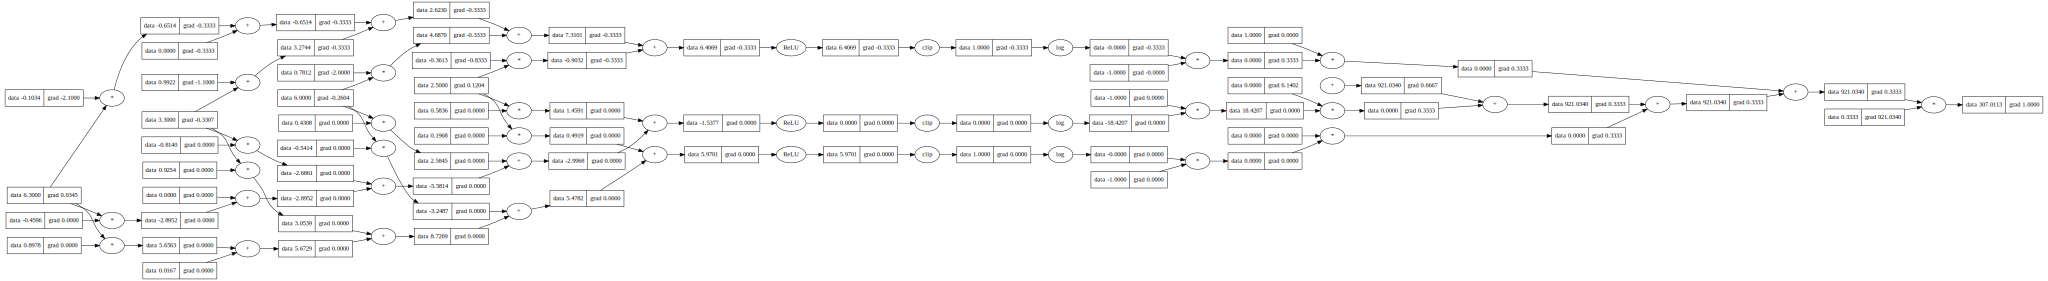

In [6]:
draw[100]